In [1]:
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.special import expit
import sys
import pandas as pd
import os
import struct

In [57]:
ds = load_digits()
X = ds.data/16.0-0.5 # normalize the input, very important
y = ds.target
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size = 0.2)

params = dict(n_hidden=50, 
              C=0.1, # tradeoff L2 regularizer
              epochs=400, # iterations
              eta=0.001,  # learning rate
              random_state=1)

In [3]:
# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
# Start with the following functions:
#    init
#    encode_labels
#    initialize weights
#    sigmoid
#    add bias (vector of ones)
#    objective function (cost and regularizer)
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_) # reshape to be W
        b1 = np.zeros((self.n_hidden, 1))
        
        W2_num_elems = (self.n_hidden)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden)
        b2 = np.zeros((self.n_output_, 1))
        
        return W1, W2, b1, b2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1 ** 2) + np.mean(W2 ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

In [4]:
# now let's add in the following functions:
#    feedforward
#    fit and predict
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # need to vectorize this computation!
        # See additional code and derivation below!
        pass
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2, self.b1, self.b2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * gradW1
            self.W2 -= self.eta * gradW2
            self.b1 -= self.eta * gradb1
            self.b2 -= self.eta * gradb2
            

        return self

In [5]:
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T
        
        gradb2 = np.sum(V2, axis=1).reshape((-1,1))
        gradb1 = np.sum(V1, axis=1).reshape((-1,1))
        
        
        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C * 2
        gradW2 += W2 * self.l2_C * 2 

        return gradW1, gradW2, gradb1, gradb2

In [6]:
class TLPVectorizedMiniBatch(TwoLayerPerceptronVectorized):
    def __init__(self, alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        # but keep other keywords
        super().__init__(**kwds)
        
    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.b1, self.b2 = self._initialize_weights()
        
        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        for k in range(self.epochs):

            # adaptive learning rate
            eta = self.eta**(1+self.decrease_const*k)# decreasing learning rate
            eta = max(eta,self.eta/1000)
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (k+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                # shuffle the data so batches ar different
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches == self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2,
                                                       self.b1,
                                                       self.b2
                                                      )
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2)

                rho_W1, rho_W2 = eta * gradW1, eta * gradW2 
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2
                
                self.b1 -= eta * gradb1 
                self.b2 -= eta * gradb2 

            self.cost_.append(mini_cost)
            
        return self

Epoch: 400/400

Accuracy: 0.9638888888888889


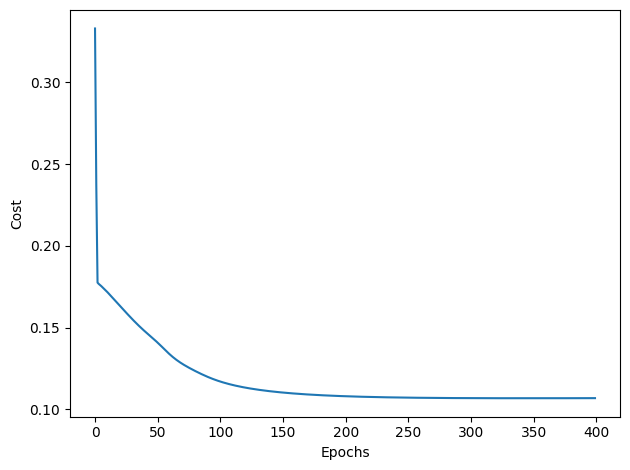

CPU times: total: 875 ms
Wall time: 2.77 s


In [58]:
%%time
nn = TwoLayerPerceptronVectorized(**params)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

Epoch: 100/100

Accuracy: 0.9638888888888889


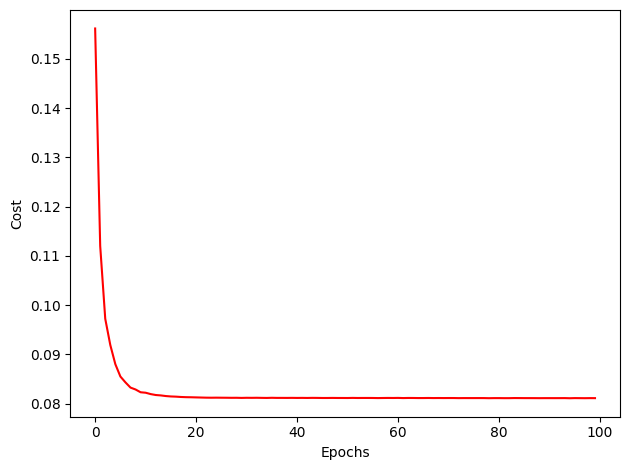

CPU times: total: 828 ms
Wall time: 1.41 s


In [59]:
%%time
params['epochs'] = 100
params['eta'] = 0.1
nn_mini = TLPVectorizedMiniBatch(**params,
                          alpha=0.1,# momentum calculation
                          decrease_const=0.1, # decreasing eta
                          minibatches=len(X_train)/32, # minibatch size
                          shuffle=True)

    
nn_mini.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

# take the mean of each minibatch epoch
cost_avgs = [np.mean(x) for x in nn_mini.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [9]:
class ThreeLayerPerceptron(TLPVectorizedMiniBatch):
    def _cost(self, A4, Y_enc, W1, W2, W3):
        '''Get the objective function value using cross-entropy loss.'''
        m = Y_enc.shape[1]
        cost = -1/m * np.sum(Y_enc * np.log(A4))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term

    def _L2_reg(self, lambda_, W1, W2, W3):
        """Compute L2-regularization cost for three layers"""
        return (lambda_) * (np.mean(W1 ** 2) + np.mean(W2 ** 2) + np.mean(W3 ** 2))

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        init_bound = np.sqrt(6. / (self.n_features_ + self.n_hidden))
        W1 = np.random.uniform(-init_bound, init_bound, (self.n_hidden, self.n_features_))
        b1 = np.zeros((self.n_hidden, 1))
        
        init_bound = np.sqrt(6. / (2 * self.n_hidden))
        W2 = np.random.uniform(-init_bound, init_bound, (self.n_hidden, self.n_hidden))
        b2 = np.zeros((self.n_hidden, 1))
        
        init_bound = np.sqrt(6. / (self.n_hidden + self.n_output_))
        W3 = np.random.uniform(-init_bound, init_bound, (self.n_output_, self.n_hidden))
        b3 = np.zeros((self.n_output_, 1))

        return W1, W2, W3, b1, b2, b3

    def _feedforward(self, X, W1, W2, W3, b1, b2, b3):
        """Compute feedforward step including third layer"""
        A1 = X.T
        Z1 = W1 @ A1 + b1
        A2 = self._sigmoid(Z1)
        Z2 = W2 @ A2 + b2
        A3 = self._sigmoid(Z2)
        Z3 = W3 @ A3 + b3
        A4 = np.exp(Z3) / np.sum(np.exp(Z3), axis=0)

        return A1, Z1, A2, Z2, A3, Z3, A4

    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation including third layer."""
        V3 = A4 - Y_enc
        V2 = A3 * (1 - A3) * (W3.T @ V3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        gradW3 = V3 @ A3.T
        gradW2 = V2 @ A2.T
        gradW1 = V1 @ A1.T

        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1, axis=1).reshape((-1, 1))

        # regularize weights that are not bias terms
        gradW1 += W1 * self.l2_C * 2
        gradW2 += W2 * self.l2_C * 2 
        gradW3 += W3 * self.l2_C * 2 

        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3

    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.b1, self.b2, self.b3 = self._initialize_weights()
        
        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape)
        rho_W2_prev = np.zeros(self.W2.shape)
        rho_W3_prev = np.zeros(self.W3.shape)

        # Initiate lists to save gradient magnitudes and costs
        self.grad_avg_mag_W1_ = []
        self.grad_avg_mag_W2_ = []
        self.grad_avg_mag_W3_ = []
        grad_mags_W1 = []
        grad_mags_W2 = []
        grad_mags_W3 = []
        self.cost_ = []

        for k in range(self.epochs):
            if print_progress > 0 and (k+1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []  # list to store cost for each mini-batch
            for idx in mini:
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[idx], self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)
                
                # Compute cost
                cost = self._cost(A4, Y_enc[:, idx], self.W1, self.W2, self.W3)
                mini_cost.append(cost)
                
                # Compute gradient via backpropagation
                gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3, Y_enc=Y_enc[:, idx], W1=self.W1, W2=self.W2, W3=self.W3)
                
                # Update weights
                rho_W1, rho_W2, rho_W3 = self.eta * gradW1, self.eta * gradW2, self.eta * gradW3
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev))
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev))
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev))
                rho_W1_prev, rho_W2_prev, rho_W3_prev = rho_W1, rho_W2, rho_W3
                
                self.b1 -= self.eta * gradb1 
                self.b2 -= self.eta * gradb2
                self.b3 -= self.eta * gradb3

                # Store gradient magnitudes for this mini-batch
                grad_mags_W1.append(np.mean(np.abs(gradW1)))
                grad_mags_W2.append(np.mean(np.abs(gradW2)))
                grad_mags_W3.append(np.mean(np.abs(gradW3)))

            # Compute and store gradient magnitudes
            self.grad_avg_mag_W1_.append(np.mean(grad_mags_W1))
            self.grad_avg_mag_W2_.append(np.mean(grad_mags_W2))
            self.grad_avg_mag_W3_.append(np.mean(grad_mags_W3))

            self.cost_.append(np.mean(mini_cost))  # append average cost of the epoch

        return self

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred

    def plot_gradient_magnitudes(self):
        """Plot the magnitude of the gradients for each layer for every epoch."""
        plt.plot(self.grad_avg_mag_W1_, label='Layer 1', color='blue')
        plt.plot(self.grad_avg_mag_W2_, label='Layer 2', color='green')
        plt.plot(self.grad_avg_mag_W3_, label='Layer 3', color='red')
        plt.ylabel('Average Gradient Magnitude')
        plt.xlabel('Epochs')
        plt.legend(loc='upper right')
        plt.tight_layout()
        plt.show()

Epoch: 100/100

Accuracy: 0.9472222222222222


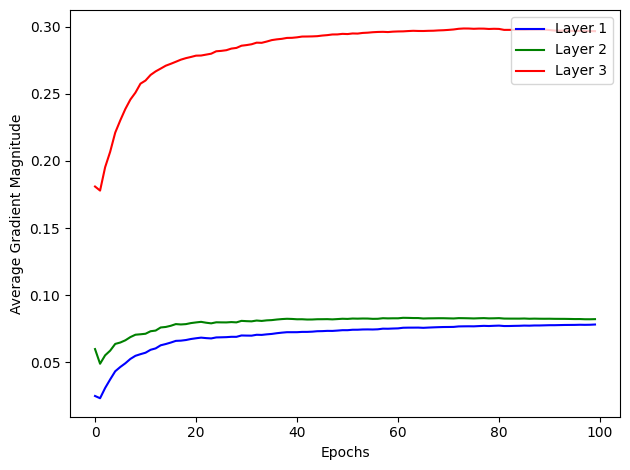

CPU times: total: 1.41 s
Wall time: 2.5 s


In [11]:
%%time
params['epochs'] = 100
params['eta'] = 0.1
nn_mini = ThreeLayerPerceptron(**params,
                          alpha=0.1,# momentum calculation
                          decrease_const=0.1, # decreasing eta
                          minibatches=len(X_train)/32, # minibatch size
                          shuffle=True)

nn_mini.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

nn_mini.plot_gradient_magnitudes()

In [51]:
import numpy as np
import pandas as pd
from scipy.special import expit
import sys
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class MultiLayerPerceptron:
    def __init__(self, layers, C=0.0, epochs=500, eta=0.001, random_state=None, 
                 alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1):
        np.random.seed(random_state)
        self.layers = layers
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
        return onehot
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        return expit(z)
    
    def _L2_reg(self):
        """Compute L2-regularization cost"""
        return self.l2_C * np.sum([np.mean(w ** 2) for w in self.W])
    
    def _cost(self, A, Y_enc):
        '''Compute the objective function value using cross-entropy loss.'''
        m = Y_enc.shape[1]
        cost = -1/m * np.sum(Y_enc * np.log(A[-1]))
        L2_term = self._L2_reg()
        return cost + L2_term
    
    def _initialize_weights(self):
        W = []
        b = []
        layer_input = self.n_features_
        for layer in self.layers:
            init_bound = np.sqrt(6. / (layer_input + layer))
            W.append(np.random.uniform(-init_bound, init_bound, (layer, layer_input)))
            b.append(np.zeros((layer, 1)))
            layer_input = layer
        init_bound = np.sqrt(6. / (layer_input + self.n_output_))
        W.append(np.random.uniform(-init_bound, init_bound, (self.n_output_, layer_input)))
        b.append(np.zeros((self.n_output_, 1)))
        return W, b
    
    def _feedforward(self, X):
        A = [X.T]
        Z = []
        for w, b in zip(self.W, self.b):
            z = w @ A[-1] + b
            Z.append(z)
            a = self._sigmoid(z)
            A.append(a)
        A[-1] = np.exp(Z[-1]) / np.sum(np.exp(Z[-1]), axis=0)  # softmax for final layer
        return A, Z
    
    def _get_gradient(self, A, Z, Y_enc):
        V = [A[-1] - Y_enc]
        for i in reversed(range(1, len(self.layers) + 1)):
            v = A[i] * (1 - A[i]) * (self.W[i].T @ V[-1])
            V.append(v)
        V = V[::-1]
        gradW = []
        gradb = []
        for i in range(len(V)):
            gradW.append(V[i] @ A[i].T)
            gradb.append(np.sum(V[i], axis=1, keepdims=True))
        return gradW, gradb
    
    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W, self.b = self._initialize_weights()
        self.cost_ = []
        self.grad_magnitudes_ = []  # Store gradient magnitudes
        
        # Correcting the progress display
        progress_interval = max(1, self.epochs // print_progress)
        
        for i in range(self.epochs):
            if print_progress > 0 and (i+1) % progress_interval == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            epoch_grads = []  # Store gradient magnitudes for this epoch
            for idx in mini:
                A, Z = self._feedforward(X_data[idx])
                cost = self._cost(A, Y_enc[:, idx])
                mini_cost.append(cost)
                gradW, gradb = self._get_gradient(A=A, Z=Z, Y_enc=Y_enc[:, idx])
                grad_mags = [np.linalg.norm(gw) for gw in gradW]  # Compute gradient magnitudes
                epoch_grads.append(grad_mags)
                for w, grad_w, b, grad_b in zip(self.W, gradW, self.b, gradb):
                    w -= self.eta * grad_w
                    b -= self.eta * grad_b
            self.cost_.append(mini_cost)
            self.grad_magnitudes_.append(np.mean(epoch_grads, axis=0))  # Average gradient magnitude over minibatches
            
        return self

    def predict(self, X):
        """Predict class labels"""
        A, _ = self._feedforward(X)
        y_pred = np.argmax(A[-1], axis=0)
        return y_pred

In [52]:
# Test the updated MultiLayerPerceptron
layer_configs = [
    [50],  # three layers: input + 1 hidden + output
    [50, 50],  # four layers: input + 2 hidden + output
    [50, 50, 50]  # five layers: input + 3 hidden + output
]

ds = load_digits()
X = ds.data / 16.0 - 0.5  # normalize the input
y = ds.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

results = {}
gradient_magnitudes = {}
for config in layer_configs:
    nn = MultiLayerPerceptron(layers=config, C=0.1, epochs=100, eta=0.1, random_state=1, 
                              minibatches=len(X_train)/32, shuffle=True)
    nn.fit(X_train, y_train, print_progress=10)
    yhat = nn.predict(X_test)
    accuracy = accuracy_score(y_test, yhat)
    results[tuple(config)] = accuracy
    gradient_magnitudes[tuple(config)] = nn.grad_magnitudes_

results

Epoch: 100/100

{(50,): 0.9777777777777777, (50, 50): 0.9777777777777777, (50, 50, 50): 0.975}

Epoch: 100/100

Accuracy: 0.9805555555555555


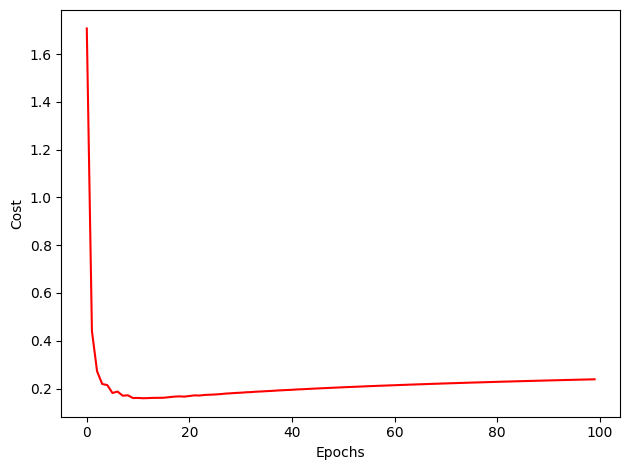

In [67]:
ds = load_digits()
X = ds.data/16.0-0.5 # normalize the input, very important
y = ds.target
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size = 0.2)

paramsmlp = dict(layers=[50], 
              C=0.1, # tradeoff L2 regularizer
              epochs=100, # iterations
              eta=0.1,  # learning rate
              random_state=1,
              alpha=0.1,# momentum calculation
              decrease_const=0.1, # decreasing eta
              minibatches=len(X_train)/32, # minibatch size
              shuffle=True)
    
# nn_mini.fit(X_train, y_train, print_progress=50)
# yhat = nn.predict(X_test)
# print('Accuracy:',accuracy_score(y_test,yhat))

# # take the mean of each minibatch epoch
# cost_avgs = [np.mean(x) for x in nn_mini.cost_]

# plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
# plt.ylabel('Cost')
# plt.xlabel('Epochs')
# plt.tight_layout()
# plt.show()

nn = MultiLayerPerceptron(**paramsmlp)

nn.fit(X_train, y_train, print_progress=50)
yhat = nn.predict(X_test)
print('Accuracy:',accuracy_score(y_test,yhat))

# take the mean of each minibatch epoch
cost_avgs = [np.mean(x) for x in nn.cost_]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

# plt.plot(range(len(nn.cost_)), nn.cost_)
# plt.ylabel('Cost')
# plt.xlabel('Epochs')
# plt.tight_layout()
# plt.show()

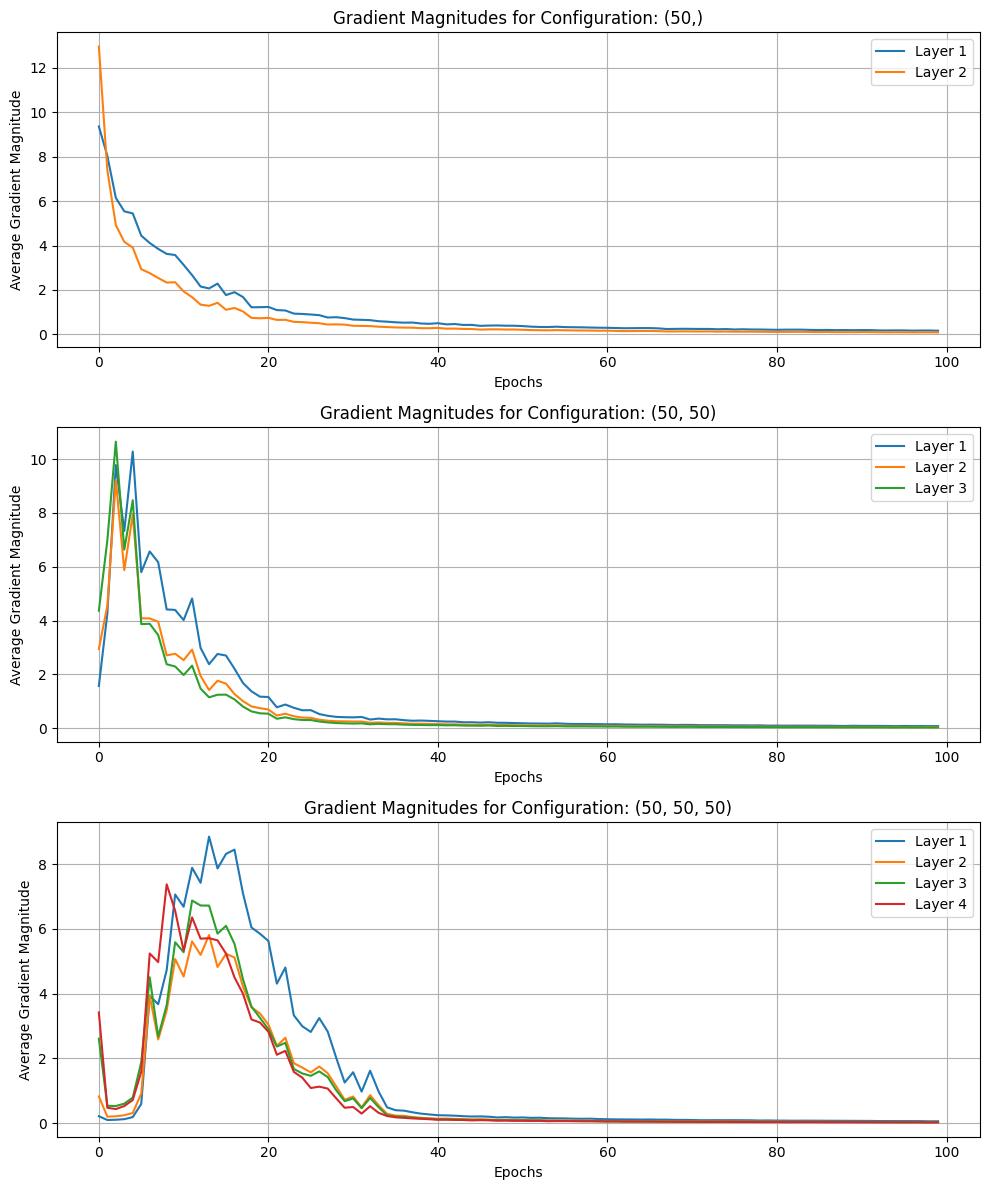

In [53]:
# Plotting the gradient magnitudes
fig, axes = plt.subplots(nrows=len(layer_configs), figsize=(10, 12))

for ax, (config, grads) in zip(axes, gradient_magnitudes.items()):
    grads = np.array(grads)
    for i in range(grads.shape[1]):
        ax.plot(grads[:, i], label=f'Layer {i+1}')
    ax.set_title(f'Gradient Magnitudes for Configuration: {config}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Average Gradient Magnitude')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [54]:
class MultiLayerPerceptronAdaptive(MultiLayerPerceptron):
    def __init__(self, layers, adaptive=None, C=0.0, epochs=500, eta=0.001, 
                 beta1=0.9, beta2=0.999, epsilon=1e-7, random_state=None, 
                 alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1):
        super().__init__(layers, C, epochs, eta, random_state, alpha, decrease_const, shuffle, minibatches)
        self.adaptive = adaptive
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

    def _initialize_weights(self):
        W, b = super()._initialize_weights()
        if self.adaptive:
            self.M_W = [np.zeros(w.shape) for w in W]
            self.M_b = [np.zeros(bi.shape) for bi in b]
            self.S_W = [np.zeros(w.shape) for w in W]
            self.S_b = [np.zeros(bi.shape) for bi in b]
        return W, b
    
    def _update_weights(self, gradW, gradb, t):
        for i, (w, grad_w, b, grad_b) in enumerate(zip(self.W, gradW, self.b, gradb)):
            if self.adaptive == "rmsprop":
                self.S_W[i] = self.beta2 * self.S_W[i] + (1 - self.beta2) * grad_w**2
                w -= self.eta * grad_w / (np.sqrt(self.S_W[i]) + self.epsilon)
                
                self.S_b[i] = self.beta2 * self.S_b[i] + (1 - self.beta2) * grad_b**2
                b -= self.eta * grad_b / (np.sqrt(self.S_b[i]) + self.epsilon)
            
            elif self.adaptive == "adam" or self.adaptive == "adamw":
                self.M_W[i] = self.beta1 * self.M_W[i] + (1 - self.beta1) * grad_w
                self.S_W[i] = self.beta2 * self.S_W[i] + (1 - self.beta2) * grad_w**2
                m_w_corrected = self.M_W[i] / (1 - self.beta1**t)
                s_w_corrected = self.S_W[i] / (1 - self.beta2**t)
                w -= self.eta * m_w_corrected / (np.sqrt(s_w_corrected) + self.epsilon)
                
                self.M_b[i] = self.beta1 * self.M_b[i] + (1 - self.beta1) * grad_b
                self.S_b[i] = self.beta2 * self.S_b[i] + (1 - self.beta2) * grad_b**2
                m_b_corrected = self.M_b[i] / (1 - self.beta1**t)
                s_b_corrected = self.S_b[i] / (1 - self.beta2**t)
                b -= self.eta * m_b_corrected / (np.sqrt(s_b_corrected) + self.epsilon)
                
                if self.adaptive == "adamw":
                    w -= self.eta * self.l2_C * w
                    b -= self.eta * self.l2_C * b
                
            else:
                w -= self.eta * grad_w
                b -= self.eta * grad_b

    def fit(self, X, y, print_progress=0):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W, self.b = self._initialize_weights()
        self.cost_ = []
        self.grad_magnitudes_ = []
        
        progress_interval = max(1, self.epochs // print_progress)
        
        for i in range(self.epochs):
            if print_progress > 0 and (i+1) % progress_interval == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
                
            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]
                
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            epoch_grads = []
            
            for idx in mini:
                A, Z = self._feedforward(X_data[idx])
                cost = self._cost(A, Y_enc[:, idx])
                mini_cost.append(cost)
                gradW, gradb = self._get_gradient(A=A, Z=Z, Y_enc=Y_enc[:, idx])
                grad_mags = [np.linalg.norm(gw) for gw in gradW]
                epoch_grads.append(grad_mags)
                
                self._update_weights(gradW, gradb, i+1)
            
            self.cost_.append(mini_cost)
            self.grad_magnitudes_.append(np.mean(epoch_grads, axis=0))
        
        return self

In [55]:
# Testing the updated MultiLayerPerceptron with adaptive techniques
adaptive_techniques = [None, "rmsprop", "adam", "adamw"]
results_adaptive = {}
gradient_magnitudes_adaptive = {}

for technique in adaptive_techniques:
    nn = MultiLayerPerceptronAdaptive(layers=[50, 50, 50], C=0.1, epochs=100, eta=0.1, random_state=1, 
                                      minibatches=len(X_train)/32, shuffle=True, adaptive=technique)
    nn.fit(X_train, y_train, print_progress=10)
    yhat = nn.predict(X_test)
    accuracy = accuracy_score(y_test, yhat)
    results_adaptive[technique] = accuracy
    gradient_magnitudes_adaptive[technique] = nn.grad_magnitudes_

results_adaptive

Epoch: 100/100

{None: 0.975,
 'rmsprop': 0.1111111111111111,
 'adam': 0.10277777777777777,
 'adamw': 0.9472222222222222}

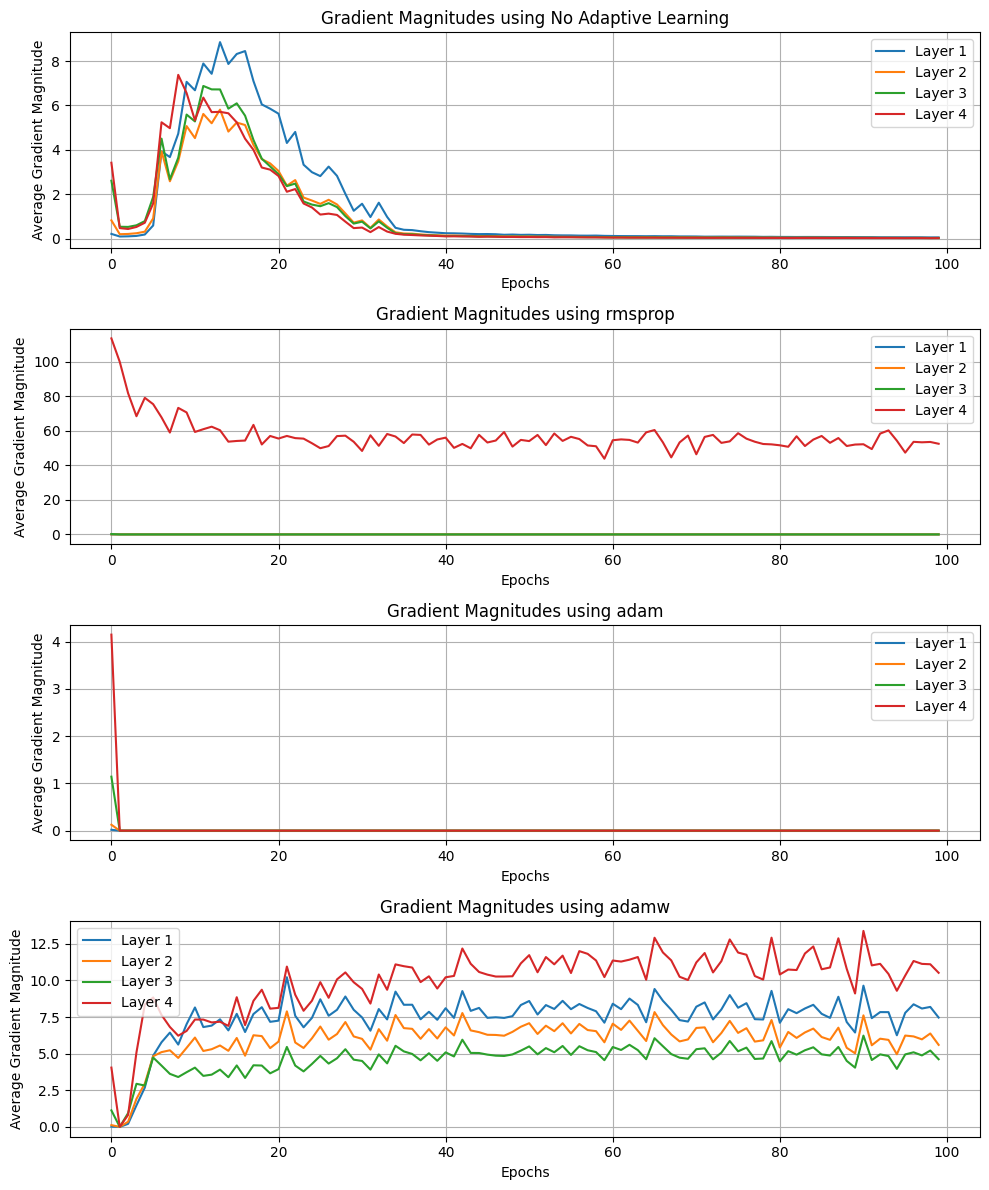

In [56]:
# Plotting the gradient magnitudes for adaptive techniques
fig, axes = plt.subplots(nrows=len(adaptive_techniques), figsize=(10, 12))

for ax, (technique, grads) in zip(axes, gradient_magnitudes_adaptive.items()):
    grads = np.array(grads)
    for i in range(grads.shape[1]):
        ax.plot(grads[:, i], label=f'Layer {i+1}')
    ax.set_title(f'Gradient Magnitudes using {technique if technique else "No Adaptive Learning"}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Average Gradient Magnitude')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()
